# demonstration of the filtering steps applied to raw eye-tracking data

In [1]:
from __future__ import division
import os
from os.path import join
import sys
import pandas as pd
import numpy as np
import cv2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load Data

In [2]:
raw_df = pd.read_table('../../Results/AVB_0055/AVB_0055_eyeData.txt')

In [3]:
# show glimpse of the data/variables we're working with
raw_df.iloc[680:686]

,trialNum,timeStamp,stimType,isInverted,fix-X,fix-Y,imageName,rect-X1,rect-Y1,rect-X2,rect-Y2,validity,gaze-X,gaze-Y,eyeDistance
680,1,11324,image,0,na,na,hmnBG/hmnBG_23.jpg,357,158,922,865,0,738,415,615
681,1,11340,image,0,na,na,hmnBG/hmnBG_23.jpg,357,158,922,865,0,733,418,615
682,1,11357,image,0,na,na,hmnBG/hmnBG_23.jpg,357,158,922,865,0,739,413,616
683,1,11374,image,0,na,na,hmnBG/hmnBG_23.jpg,357,158,922,865,0,735,409,616
684,1,11390,image,0,na,na,hmnBG/hmnBG_23.jpg,357,158,922,865,0,736,413,616
685,1,11407,image,0,na,na,hmnBG/hmnBG_23.jpg,357,158,922,865,0,734,415,616


In [4]:
# extract the data from a single trial
trialNum = 1
trial_df = raw_df[raw_df.trialNum == trialNum]

# load the background image
imageName = trial_df.imageName[trial_df.stimType == 'image'].iloc[0]
bgStim = cv2.imread(join('../../Stimuli', imageName))
bgStim = cv2.cvtColor(bgStim, cv2.COLOR_BGR2RGB)

# resize the bg image to match appearance during task
imW = trial_df.loc[trial_df.stimType == 'image','rect-X2'].iloc[0] - trial_df.loc[trial_df.stimType == 'image','rect-X1'].iloc[0]
imH = trial_df.loc[trial_df.stimType == 'image','rect-Y2'].iloc[0] - trial_df.loc[trial_df.stimType == 'image','rect-Y1'].iloc[0]

bgStim = cv2.resize(bgStim, (imW, imH))


### Raw Data Filtering

In [5]:
# grab the X,Y values for fixation cross
fixCrossX = int(trial_df['fix-X'].iloc[0])
fixCrossY = int(trial_df['fix-Y'].iloc[0])

# isolate the timepoints during the "image" portion of each trial
trial_df = trial_df[trial_df.stimType == 'image']

# make a copy for comparison purposes later on
ORIG_trial_df = trial_df.copy()

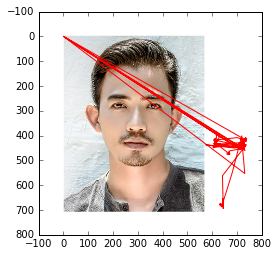

In [6]:
# Plot the raw gaze locations
plt.imshow(bgStim)
plt.plot(trial_df['gaze-X'], trial_df['gaze-Y'], 'r-')

In [7]:
# translate gaze coordinates to be relative to the stimulus (instead of screen)
stimLocation = [trial_df['rect-X1'].iloc[0], trial_df['rect-Y1'].iloc[0]] # [x1,y1] of stimulus on screen
trial_df.loc[:,'gaze-X'] = trial_df.loc[:,'gaze-X'] - stimLocation[0]
trial_df.loc[:,'gaze-Y'] = trial_df.loc[:,'gaze-Y'] - stimLocation[1]

# do the same for the fixation cross location col
trial_df.loc[:,'fix-X'] = fixCrossX - stimLocation[0]
trial_df.loc[:,'fix-Y'] = fixCrossY - stimLocation[1]

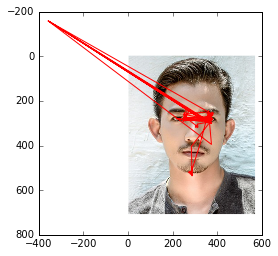

In [8]:
# Plot the gaze locations relative to stim
plt.imshow(bgStim)
plt.plot(trial_df['gaze-X'], trial_df['gaze-Y'], 'r-')

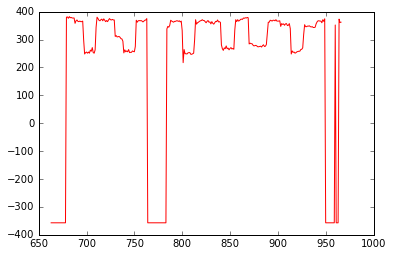

In [9]:
# plot just the X-values
plt.plot(trial_df['gaze-X'], 'r-')

### interpolate over missing data points

In [10]:
# Set sampling frequency
sampleHz = 60

# set invalid gaze pts to None
trial_df.loc[trial_df.validity > 0, ['gaze-X','gaze-Y','eyeDistance']] = np.nan

# maximum window size (in ms) to interpolate over
max_interp_window = 50 # conservative estimate of blink length  

# convert interp_window from ms to # of samples
interp_limit = np.floor(max_interp_window/(1/sampleHz*1000))
print interp_limit

# interpolate missing values within window limits
trial_df.fillna(method='ffill', limit=interp_limit, inplace=True)
# for col in ['gaze-X','gaze-Y','eyeDistance']:
#     trial_df.loc[:,col].interpolate(limit=interp_limit, 
#                              limit_direction='both',
#                              inplace=True)

# update the valid datapts column to reflect new values
trial_df.loc[~np.isnan(trial_df['gaze-X']), 'validity'] = 0

3.0


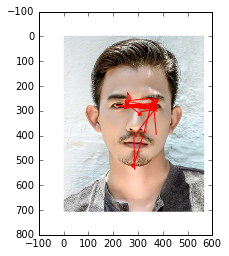

In [11]:
# Plot the interpolated gaze locations relative to stim
plt.imshow(bgStim)
plt.plot(trial_df['gaze-X'], trial_df['gaze-Y'], 'r-')


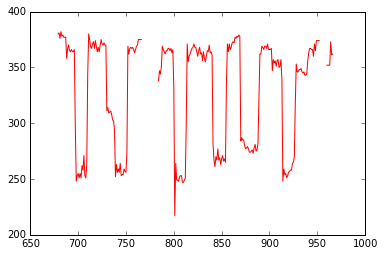

In [12]:
# plot interpolated X-values
plt.plot(trial_df['gaze-X'], 'r-')

### Define Fixations
The output from this step will be a dataframe with each row representing a unique gazepoint/datapoint in the trial. There will also be a column indicating whether each datapoint belongs to a "fixation" or not (if so, the value in this column will indicated the ordinal value of that particular fixation)

#### define based on a Dispersion Threshold algorithm (I-DT)

In [13]:
class FixationFilter_IDT():
    """
    Dispersion Threshold Filter (based on Salvucci et al. (2000))
    """
    def __init__(self):
        # Dispersion parameters
        self.minDuration = 100      # minimum fixation duration (ms)
        self.maxDispersion = 1.5      # maximum dispersion (degrees of vis angle)
        
        self.screenSize_mm = (340, 270)   # screen size (mm)
        self.screenSize_px = (1280, 1024) # screen size (px)
        self.px2mm = self.screenSize_mm[0]/self.screenSize_px[0]
        
        self.fixCounter = 1          # initialize fixation counter for labeling
        
    def applyFilter(self, df):
        """
        Apply the filter to the input dataframe. 
        Return the dataframe with fixation labels column included
        """
        n_tmpts = df.shape[0]

        # initialize fixNumber array (this will store corresponding fix number for each datapt)
        fixNumber = np.zeros(shape=(n_tmpts))

        start = 0
        end = 0
        while end+1 < n_tmpts:
            
            # skip invalid timepts
            if (df.validity.iloc[start] == 0) and (df.validity.iloc[end] == 0):

                # timestamp at start of window
                startTS = df.timeStamp.iloc[start]

                # build window to cover the min duration threshold
                while end+1 < n_tmpts and ((df.timeStamp.iloc[end] - startTS) < self.minDuration) and (df.validity.iloc[end] == 0):
                    end += 1

                winDuration = df.timeStamp.iloc[end] - df.timeStamp.iloc[start]
                if winDuration >= self.minDuration:
                    
                    # calculate dispersion over current window
                    disp = self.dispersion(df, start, end)

                    # if less than threshold
                    if (disp < self.maxDispersion) and (end+1 < n_tmpts):
                        
                        # increase window til it passes threshold
                        while (self.dispersion(df, start, end) < self.maxDispersion) and (end+1 < n_tmpts) and df.validity.iloc[end+1] == 0:
                            end += 1
                        
                        fixDuration = df.timeStamp.iloc[end] - startTS

                        # mark all of these points as fixations, assign appropriate number
                        fixNumber[start:end] = self.fixCounter
                        self.fixCounter += 1

                        # reset values
                        end += 2   # skip one to insert saccade
                        start = end
                    else:
                        start += 1
                else:
                    start+=1
                    end+=1
            else:
                start += 1
                end += 1
        
        # add the fixation number label to original array
        fixNumber[fixNumber == 0] = np.nan  # set fixNumber=0 to nan
        df['fixNumber'] = fixNumber  
        return df
    
    def dispersion(self, df, winStart, winEnd):
        """
        Calculate the X,Y dispersion over the given window
        Return dispersion expressed in visual angle
        """
        # get X,Y values for this window
        xVals = df['gaze-X'].iloc[winStart:winEnd+1]
        yVals = df['gaze-Y'].iloc[winStart:winEnd+1]
        disp = (xVals.max()-xVals.min() + yVals.max()-yVals.min())
        
        # convert from px to mm
        disp = disp * self.px2mm

        # convert from mm to visual angle
        dist = np.mean(df['eyeDistance'].iloc[winStart:winEnd+1])   # mean eye-distance over window (mm)
        disp = np.rad2deg(2 * np.arctan((disp/2)/dist))
        
        return disp
        

In [14]:
# create filter object, and pass trial dataframe through it
dtFilt = FixationFilter_IDT()
trial_df = dtFilt.applyFilter(trial_df)

In [15]:
# show glimpse of output dataframe
trial_df.iloc[20:26]

,trialNum,timeStamp,stimType,isInverted,fix-X,fix-Y,imageName,rect-X1,rect-Y1,rect-X2,rect-Y2,validity,gaze-X,gaze-Y,eyeDistance,fixNumber
683,1,11374,image,0,528,312,hmnBG/hmnBG_23.jpg,357,158,922,865,0,378.0,251.0,616.0,1.0
684,1,11390,image,0,528,312,hmnBG/hmnBG_23.jpg,357,158,922,865,0,379.0,255.0,616.0,1.0
685,1,11407,image,0,528,312,hmnBG/hmnBG_23.jpg,357,158,922,865,0,377.0,257.0,616.0,1.0
686,1,11424,image,0,528,312,hmnBG/hmnBG_23.jpg,357,158,922,865,0,377.0,260.0,616.0,1.0
687,1,11440,image,0,528,312,hmnBG/hmnBG_23.jpg,357,158,922,865,0,377.0,251.0,616.0,1.0
688,1,11457,image,0,528,312,hmnBG/hmnBG_23.jpg,357,158,922,865,0,358.0,270.0,615.0,1.0


#### Show Fixation Locations

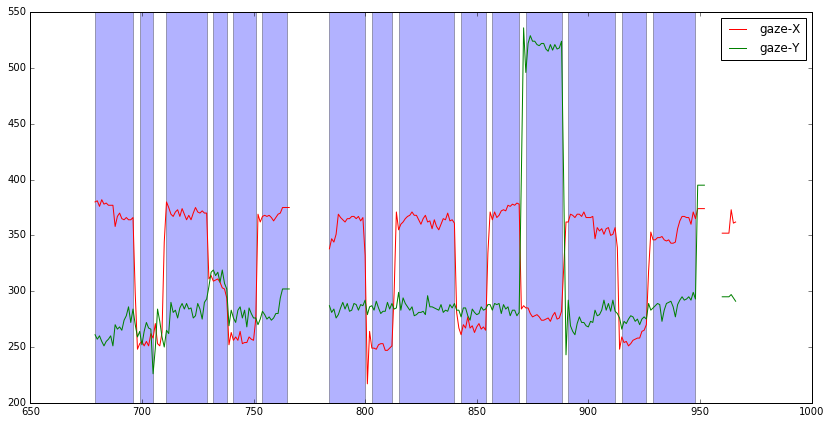

In [16]:
plt.figure(figsize=(14, 7))

# draw fixation areas
for f in np.unique(trial_df.fixNumber):
    if f>0:
        fix_df = trial_df.loc[trial_df.fixNumber == f]
        plt.axvspan(fix_df.index[0], fix_df.index[-1], facecolor='blue', alpha=.3)

# draw the gaze locations in each dimension
plt.plot(trial_df['gaze-X'], '-r', lw=1)
plt.plot(trial_df['gaze-Y'], '-g', lw=1)
plt.legend()

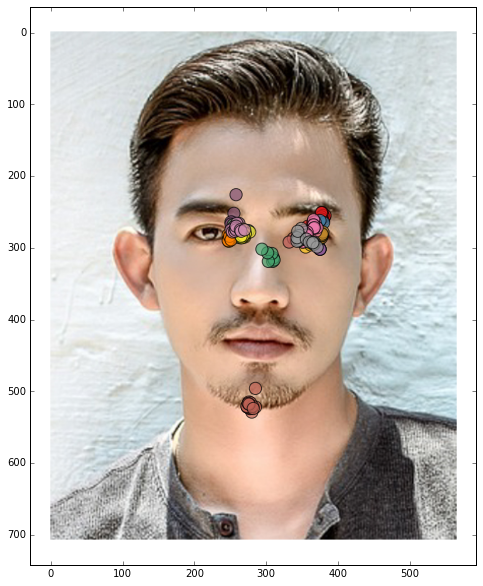

In [17]:
# show gaze locations color-coded by distinct fixations

plt.figure(figsize=(10, 10))

tmp = trial_df.loc[trial_df.fixNumber>0, :]
plt.imshow(bgStim)
plt.scatter(tmp['gaze-X'], tmp['gaze-Y'], c=tmp['fixNumber'], s=150, alpha=.7, cmap='Set1')


## Summarize Fixations

### create class for loading AOI images, storing coordinates

In [18]:
class AOIs:
    """
    Class to work with specified AOI image file, store each AOIs coordinates
    Input:  -2D ndarray containing unique AOI labels by number
            -scaleFactor: scale factor between AOI image and displayed stim size during the task
    """
    def __init__(self, AOIimage, scaleFactor):

        # calculate scale factor between AOI image and displayed image
        self.scaleFactor = scaleFactor
        self.AOI = AOIimage
        self.isInverted = False

        # flip image if necessary
        if self.isInverted:
            self.AOI = np.flipud(self.AOI) 		# flip the image upside down

        # extract the unique, nonzero, values in this AOI
        self.AOI_codes = np.unique(self.AOI[self.AOI > 0])

        #### CREATE DICT TO STORE EACH AOIS COORDS
        self.AOIs = {}				# dicitionary to store all of the AOIs and coordinates
        for val in self.AOI_codes:
            self.this_AOI = self.AOI == val 					# make a unique image for this value only
            self.Xcoords = np.where(self.this_AOI==True)[1]		# pull out x-coordinates for this AOI (NOTE: remember, (row,col) convention means (y,x))
            self.Ycoords = np.where(self.this_AOI==True)[0]		# pull out y-coordinates for this AOI
            self.coords = [(self.Xcoords[x], self.Ycoords[x]) for x in range(len(self.Xcoords))]	# convert to list of tuples

            # map values to names
            if val == 64:
                self.AOI_name = 'rightEye'
            elif val == 128:
                self.AOI_name = 'leftEye'
            elif val == 191:
                self.AOI_name = 'nose'
            elif val == 255:
                self.AOI_name = 'mouth'
            else:
                print 'AOI image has value of: ' + str(val) + '. Not found in key.'

            # store names and coordinates in dictionary (NOTE: coordinates are stored as (x,y) pairs...so: (column, row))
            self.AOIs[self.AOI_name] = self.coords


    def isAOI(self, coordinates):
        "check if the specified coordinates fall into one of the AOIs"

        # scale coordinates
        self.x = np.round(coordinates[0] * self.scaleFactor) #.astype('uint8')
        self.y = np.round(coordinates[1] * self.scaleFactor) #.astype('uint8')
        self.this_coord = (self.x, self.y)

        # loop through the AOIs in the dictionary until you find which (if any) it belongs to
        self.found_AOI = False
        for name, coords in self.AOIs.iteritems():
            if self.this_coord in coords:
                self.AOI_label = name
                self.found_AOI = True
                break

        if not self.found_AOI:
            self.AOI_label = 'none'

        return self.AOI_label

In [19]:
# Prep AOI file for this trial
AOI_imageName = imageName.split('/')[1][:-4] + '_AOIs.png'
AOI_stim = cv2.imread(join('../../Stimuli/AOIs/finished_AOIs', AOI_imageName))
AOI_stim = AOI_stim[:,:,0]       # grab first color channel only (other 2 are redundant)

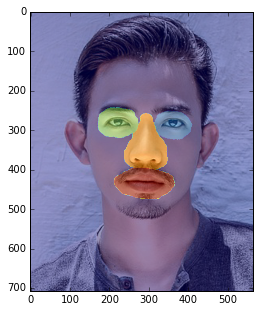

In [20]:
# show AOIs overlaid on BG image
tmpAOI_stim = cv2.resize(AOI_stim, (imW, imH))   # resize a tmp AOI image, just for viewing purposes
plt.figure(figsize=(4,5))
plt.imshow(bgStim)
plt.imshow(tmpAOI_stim, alpha=.4)

In [21]:
# Instantiate AOI object
scaleFactor = AOI_stim.shape[1]/imW      # scale factor necessary for converting gaze coords to AOI dimensions
trialAOIs = AOIs(AOI_stim, scaleFactor)

### Iterate over unique fixations in the trial dataframe, and summarize gaze behavior within each
The output of this step will be a dataframe with one row per fixation in the trial. Columns will represent the different dependent variables calculated on each fixation

In [22]:
# calculate pixel to mm scaling factor
screenSize_mm = (340, 270)  # screen size (mm)
screenSize_px = (1280, 1024) # screen size (px)
px2mm = screenSize_mm[0]/screenSize_px[0]

# check if there are any valid fixations during this trial
if np.nansum(trial_df.fixNumber) > 0:

    # loop through each unique fixation
    fixLabels = trial_df.fixNumber.unique()
    for i,fixNum in enumerate(fixLabels[~np.isnan(fixLabels)]):

        # pull out the rows for this fixation
        fix_df = trial_df.loc[trial_df.fixNumber == fixNum, :]

        # calculate fixation duration
        fixDuration = fix_df.timeStamp.iloc[-1] - fix_df.timeStamp.iloc[0]

        # calculate centroid location for fixation
        fixPosX, fixPosY = np.ceil(np.mean(fix_df.loc[:, 'gaze-X':'gaze-Y']))

        # calculate the mean eye-distance during this fixation (needed to convert subsequent values from px to vis angle)
        fixEyeDist = np.mean(fix_df.eyeDistance)

        # calculate distance from previous fixation
        if i == 0:
            # if its the first fixation, use the fixation cross location
            prevFix_X = fix_df['fix-X'].iloc[0]
            prevFix_Y = fix_df['fix-Y'].iloc[0]
        distX = abs(fixPosX-prevFix_X)
        distY = abs(fixPosY-prevFix_Y)
        distPrev = np.sqrt(distX**2 + distY**2)   # do some hypoteneuse calculating
        distPrev = distPrev * px2mm              # convert distance to mm
        distPrev = np.rad2deg(2 * np.arctan((distPrev/2)/fixEyeDist))  # convert to visual angle

        # calculate distance from center of image
        distX = abs(fixPosX-(imW/2))
        distY = abs(fixPosY-(imH/2))
        distCenter = np.sqrt(distX**2 + distY**2)
        distCenter = distCenter * px2mm
        distCenter = np.rad2deg(2 * np.arctan((distCenter/2)/fixEyeDist))

        # calculate direction of movement from previous fixation
        dx = fixPosX - prevFix_X
        dy = fixPosY - prevFix_Y
        radsFromPrev = np.arctan2(-dy, dx)   # invert dy to account for screen coordinates going from top to bottom
        radsFromPrev %= 2*np.pi              # convert to radians relative to the +x axis
        dirFromPrev = np.rad2deg(radsFromPrev) # express direction degrees

        # update the previous fixation values
        prevFix_X = fixPosX
        prevFix_Y = fixPosY

        # figure out the appropriate AOI label (if any)
        fixCoords = (fixPosX, fixPosY)
        AOI_label = trialAOIs.isAOI(fixCoords)

        # figure out which quadrant of the image the fixation falls in
        if fixPosX <= imW/2:
            horizHalf = 'left'
        else:
            horizHalf = 'right'
        if fixPosY <= imH/2:
            vertHalf = 'top'
        else:
            vertHalf = 'bot'

        # write output to new dataframe
        fixSummary = pd.DataFrame({'trialNum': trial_df.trialNum.iloc[0],
                                 'imageName': trial_df.imageName.iloc[0],
                                 'fixNumber': fixNum,
                                 'duration':fixDuration,
                                 'fixPosX': fixPosX,
                                 'fixPosY': fixPosY,
                                 'crossX': fix_df['fix-X'].iloc[0],
                                 'crossY': fix_df['fix-Y'].iloc[0],
                                 'distFromPrev': distPrev,
                                 'dirFromPrev':dirFromPrev,
                                 'distFromCenter':distCenter,
                                 'AOI': AOI_label,
                                 'vertHemi': vertHalf,
                                 'horizHemi': horizHalf}, index=[0])
        if i == 0:
            allFix_df = fixSummary
        else:
            allFix_df = pd.concat([allFix_df, fixSummary], ignore_index=True)   
else:
    # if no valid fixations in the trial, return a dataframe of nans
    allFix_df = pd.DataFrame({'trialNum': trial_df.trialNum.iloc[0],
                     'imageName': trial_df.imageName.iloc[0],
                     'fixNumber': np.nan,
                     'duration':np.nan,
                     'fixPosX': np.nan,
                     'fixPosY': np.nan,
                     'crossX': trial_df['fix-X'].iloc[0],
                     'crossY': trial_df['fix-Y'].iloc[0],
                     'distFromPrev': np.nan,
                     'dirFromPrev':np.nan,
                     'distFromCenter':np.nan,
                     'AOI': np.nan,
                     'vertHemi': np.nan,
                     'horizHemi': np.nan}, index=[0])

In [23]:
allFix_df

,AOI,crossX,crossY,dirFromPrev,distFromCenter,distFromPrev,duration,fixNumber,fixPosX,fixPosY,horizHemi,imageName,trialNum,vertHemi
0,rightEye,528,312,163.233389,3.114582,4.030947,283,1.0,372.0,265.0,right,hmnBG/hmnBG_23.jpg,1,top
1,leftEye,528,312,177.064327,2.445421,2.910710,100,2.0,255.0,259.0,left,hmnBG/hmnBG_23.jpg,1,top
2,rightEye,528,312,348.785085,2.854020,2.966460,300,3.0,371.0,282.0,right,hmnBG/hmnBG_23.jpg,1,top
3,nose,528,312,205.497551,1.176741,1.809699,100,4.0,306.0,313.0,right,hmnBG/hmnBG_23.jpg,1,top
4,leftEye,528,312,144.117863,1.958166,1.454143,167,5.0,259.0,279.0,left,hmnBG/hmnBG_23.jpg,1,top
5,rightEye,528,312,356.391531,2.766843,2.784620,183,6.0,370.0,286.0,right,hmnBG/hmnBG_23.jpg,1,top
6,rightEye,528,312,180.000000,2.540572,0.273968,267,7.0,359.0,286.0,right,hmnBG/hmnBG_23.jpg,1,top
7,leftEye,528,312,180.000000,1.862859,2.710102,150,8.0,250.0,286.0,left,hmnBG/hmnBG_23.jpg,1,top
8,rightEye,528,312,-0.000000,2.639430,2.843300,416,9.0,364.0,286.0,right,hmnBG/hmnBG_23.jpg,1,top
9,leftEye,528,312,177.614056,1.823286,2.401143,183,10.0,268.0,282.0,left,hmnBG/hmnBG_23.jpg,1,top


#### plot fixations

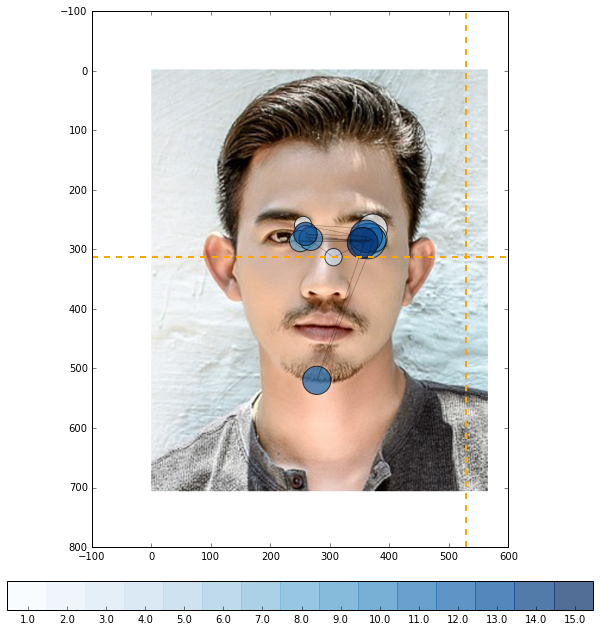

In [24]:
plt.figure(figsize=(15,12))
plt.imshow(bgStim)

nFix = allFix_df.fixNumber.max()
cmap = plt.get_cmap('Blues', nFix)    # build colormap

# plot fixations
plt.scatter(allFix_df.fixPosX, allFix_df.fixPosY,
           s=allFix_df.duration*3,
           c=np.arange(nFix),
           cmap=cmap,
           alpha=0.7)


# plot fixation lines
plt.plot(allFix_df.fixPosX, allFix_df.fixPosY, 'k', alpha=0.4, lw=.5)

# colorbar
plt.colorbar(shrink=.7, 
             cmap=cmap,
             orientation='horizontal',
             pad=0.05, 
             ticks=(np.linspace(0, nFix-1, nFix+1)+.5)).ax.set_xticklabels([str(x) for x in np.arange(1,nFix+1)])

# fixation cross location
plt.axhline(y=allFix_df.crossY.iloc[0], color='orange', ls='--', lw=2)
plt.axvline(x=allFix_df.crossX.iloc[0], color='orange', ls='--', lw=2)


### Summarize across all fixations within a single trial
Now that we have defined the fixations and summarized gaze behavior within each fixation, the next step is to summarize across all fixations in a single trial. The output from this step will be a dataframe with a single row per trial, representing various fixation summaries within that trial (e.g. proportion of trial time spent looking at the left eye)

In [25]:
allFix_df

,AOI,crossX,crossY,dirFromPrev,distFromCenter,distFromPrev,duration,fixNumber,fixPosX,fixPosY,horizHemi,imageName,trialNum,vertHemi
0,rightEye,528,312,163.233389,3.114582,4.030947,283,1.0,372.0,265.0,right,hmnBG/hmnBG_23.jpg,1,top
1,leftEye,528,312,177.064327,2.445421,2.910710,100,2.0,255.0,259.0,left,hmnBG/hmnBG_23.jpg,1,top
2,rightEye,528,312,348.785085,2.854020,2.966460,300,3.0,371.0,282.0,right,hmnBG/hmnBG_23.jpg,1,top
3,nose,528,312,205.497551,1.176741,1.809699,100,4.0,306.0,313.0,right,hmnBG/hmnBG_23.jpg,1,top
4,leftEye,528,312,144.117863,1.958166,1.454143,167,5.0,259.0,279.0,left,hmnBG/hmnBG_23.jpg,1,top
5,rightEye,528,312,356.391531,2.766843,2.784620,183,6.0,370.0,286.0,right,hmnBG/hmnBG_23.jpg,1,top
6,rightEye,528,312,180.000000,2.540572,0.273968,267,7.0,359.0,286.0,right,hmnBG/hmnBG_23.jpg,1,top
7,leftEye,528,312,180.000000,1.862859,2.710102,150,8.0,250.0,286.0,left,hmnBG/hmnBG_23.jpg,1,top
8,rightEye,528,312,-0.000000,2.639430,2.843300,416,9.0,364.0,286.0,right,hmnBG/hmnBG_23.jpg,1,top
9,leftEye,528,312,177.614056,1.823286,2.401143,183,10.0,268.0,282.0,left,hmnBG/hmnBG_23.jpg,1,top


In [26]:
stimDuration = 5000 # stimuli duration (ms)
totalFixDuration = allFix_df.duration.sum()  # total time spent on fixations within the trial

# sum fixation duration by AOI type
summedDurationByFix = allFix_df.groupby('AOI').duration.sum()

# calculate a proportion of trial time spent in each AOI
calcProportion = lambda x: x/stimDuration
trialSummary = summedDurationByFix.apply(calcProportion)

# make sure all possible AOIs are represented
for aoi in ['leftEye', 'rightEye', 'nose', 'mouth', 'none']:
    if aoi not in trialSummary.index:
        trialSummary[aoi] = 0

# add entry for proportion of time that WAS NOT a fixation
trialSummary['nonFixation'] = (stimDuration-totalFixDuration)/stimDuration

# add entry for fixation proportion combined across eyes
trialSummary['eyesCombined'] = trialSummary.loc['leftEye'] + trialSummary.loc['rightEye']

# add proportions for fixation time spent in image halves (top vs bot; left vs right)
for hemi in ['vertHemi', 'horizHemi']:
    summedDurationByHemi = allFix_df.groupby(hemi).duration.sum()
    hemiProps = summedDurationByHemi.apply(calcProportion)
    trialSummary = pd.concat([trialSummary, hemiProps])

print trialSummary

leftEye         0.1566
none            0.0532
nose            0.0200
rightEye        0.4630
mouth           0.0000
nonFixation     0.3072
eyesCombined    0.6196
bot             0.0532
top             0.6396
left            0.2098
right           0.4830
Name: duration, dtype: float64


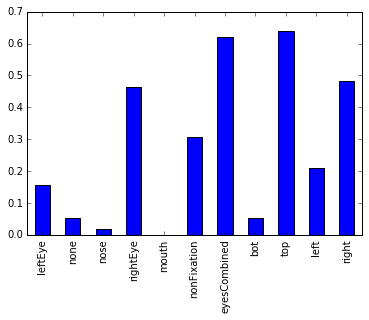

In [27]:
trialSummary.plot(kind='bar')